# EXPLORATION_11. 프로젝트 : 폐렴 진단기 성능개선

## Step 1. 실험환경 Set-up

#### 필요한 라이브러리

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 1.1 앞으로 필요한 변수들 생성

In [81]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기
데이터를 열어보면 이미 train, val(validation), test 로 나누어져 있다.

In [83]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


**결과**
- train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있다.
- 개수 비는 89%, 10.7%, 0.3% 이다.

### 2.1 train -> val 데이터 조정
- val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져온다. 
- train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할할 것이다.

In [84]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))
print(len(test_filenames))

4185
1047
624


**정리**
 
 - 이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있다.
 
 ### 2.2 train 데이터 안에 정상 이미지 수와 폐렴 이미지 수

In [85]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

print('--'*50)

# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person569_bacteria_2360.jpeg
----------------------------------------------------------------------------------------------------
Normal images count in training set: 1072
Pneumonia images count in training set: 3113


### 2.3 tf.data 인스턴스
-  tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해준다.

In [86]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

### 2.4 Train 데이터셋, validation 데이터셋 개수 확인

In [87]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [91]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 2.5 이미지 데이터 조정

- 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다.
- 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여본다.

**- decode_img 함수와 process_path 함수를 만들것이다.**

- process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경한다
**get_label을 이용해서 라벨 값을 가져온다**

In [92]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

** train 데이터 셋과 validation 데이터 셋을 만든다.**
- num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해준다

In [93]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

**이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해본다**

In [94]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


**정리**
- 참고로, 코드에서 train_ds.take(1)은 하나의 데이터만 가져온다는 의미이다.

**위에서 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 본다. 그리고 데이터 개수도 확인해본다**

In [95]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 2.6 좌우반전 augmentation 

**진행과정정리**

(1) Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다.
(2) 밑에 있는 prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜준다.
(3)shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.

(3) repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다

- 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 된다. repeat()를 사용하면 자동으로 데이터를 맞춰준다. 

(4) batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어진다.

- 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 된다. 

(5) prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다

In [96]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [97]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (32, 180, 180, 3)
Label:  [ True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True False  True
  True  True  True  True  True False False  True]


## Step 3. 데이터 시각화

- 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출한다.
- 추출된 배치를 image와 label 데이터 셋으로 나눈다.
- 이제 show_batch() 함수를 이용해서 결과 사진을 본다.

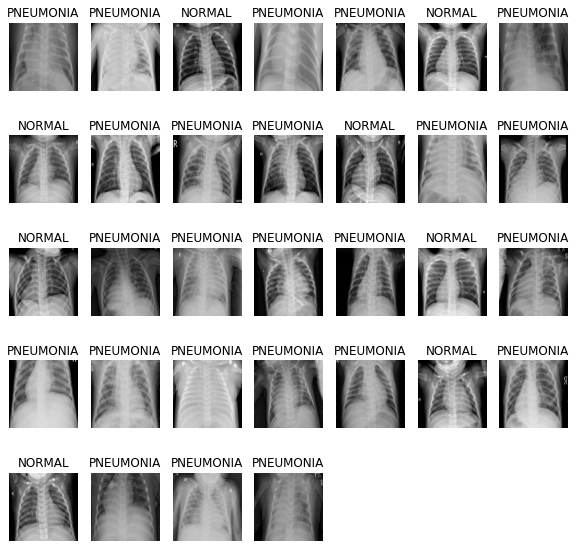

In [98]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링
- 가장 대표적인 딥러닝 모델인 CNN을 모델링하고 결과를 만들어 본다
- 먼저, Convolution block을 만든다.
- conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결한다.
- 그리고 Max Pooling을 한다.

In [99]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

**Dense Block은 아래와 같이 만든다**

In [100]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

**모델생성**

In [131]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.4),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

- 'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었다.
- 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다.
- 이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용된다.
- eight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다.
- Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있다.

**아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅한다.**
** 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정된다.**

In [132]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련
- 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택한다.
- 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언한다.
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용한다. optimizer로 'adam'을 사용한다.
- 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용한다.

In [133]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

### 6.1  모델  fit
- 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어준다.

In [134]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 39s 248ms/step - loss: 0.7470 - accuracy: 0.6020 - precision: 0.8435 - recall: 0.5761 - val_loss: 0.6520 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 32s 244ms/step - loss: 0.3005 - accuracy: 0.8679 - precision: 0.9726 - recall: 0.8449 - val_loss: 0.6782 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 32s 244ms/step - loss: 0.1788 - accuracy: 0.9309 - precision: 0.9855 - recall: 0.9206 - val_loss: 0.8943 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 32s 246ms/step - loss: 0.1666 - accuracy: 0.9344 - precision: 0.9815 - recall: 0.9306 - val_loss: 1.1592 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 32s 246ms/step - loss: 0.1600 - accura

## Step 7. 결과 확인
**그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여준다**

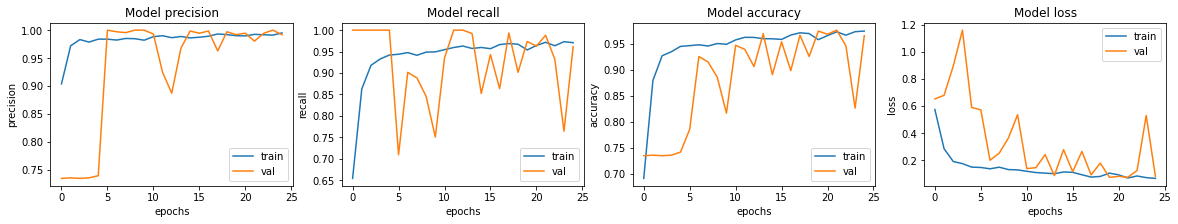

In [135]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**테스트 데이터로 모델 평가를 해본다 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해본다**

In [136]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 3s 139ms/step - loss: 0.7325 - accuracy: 0.8173 - precision: 0.7805 - recall: 0.9846
Loss: 0.7324921488761902,
Accuracy: 0.817307710647583,
Precision: 0.7804877758026123,
Recall: 0.9846153855323792


### 7.1 모델 평가 

1차 Test
- BATCH_SIZE =  20, EPOCHS : 29, Dropout: 0.2
- Accuracy = 74%, Recall = 98%
 
2차 Test - BATCH_SIZE만 줄였을 때 
- BATCH_SIZE =  16, EPOCHS : 29, Dropout: 0.2
- Accuracy = 77%, Recall = 97%

3차 Test - BATCH_SIZE와 EPOCHS 둘다 줄였을 때 
- BATCH_SIZE =  16, EPOCHS : 25, Dropout: 0.2
- Accuracy = 74%, Recall = 99%

4차 Test - BATCH_SIZE와 EPOCHS 그대로 Dropout을 0.4로 했을 때 
- BATCH_SIZE =  16, EPOCHS : 25, Dropout: 0.4
- Accuracy = 85%, Recall = 91%

5차 Test - BATCH_SIZE만 늘였을 때 
- BATCH_SIZE =  32, EPOCHS : 25, Dropout: 0.2
- Accuracy = 86%, Recall = 93%

6차 Test - BATCH_SIZE와 Dropout을 늘였을 때 
- BATCH_SIZE =  32, EPOCHS : 25, Dropout: 0.4
- Accuracy = 83%, Recall = 97%

7차 Test - 결과가 제일 좋은 것 중에서  Dropout제거
- BATCH_SIZE =  32, EPOCHS : 25, 
- Accuracy = 73%, Recall = 99%

### 7.2 정리
1. 결과가 가장 잘 나온 것은 4차, 5차Test가 제일 비슷하게 나왔다.
2. 돌렸던 모델을 같은 값으로 재실행하게 되면 똑같은 값이 나오지않는다.
- 예를 들어서 5차Test를 값을 다시 돌렸을 때  Accuracy: 67%로 떨어졌다. 하지만 Recall: 100%가 나왔다. 
3. Test중에서 Recall이 제일 높게 나온 것은 Dropout제거했을 때 가장 높게 나왔다. 
4. 테스트의 결과 폐련진단은 약 75~80%정도 맞출수 있다는 것을 알 수 있었다. 